In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import pandas as pd
import glob
import plotly.graph_objects as go
from functools import reduce

In [3]:
# Chemin vers les fichiers Excel (ajustez selon votre cas)
fichiers = glob.glob("/content/drive/MyDrive/ISR - ESG/*.xlsx")  # Adapter le chemin

# Liste pour stocker les DataFrames
dfs = []

# Charger chaque fichier Excel et l'ajouter à la liste
for fichier in fichiers:
    df = pd.read_excel(fichier,sheet_name=0, dtype={'ISIN': str})  # Lire en conservant ISIN comme string
    dfs.append(df)

df = pd.read_excel('/content/drive/MyDrive/ISR - ESG/Implication dans des produits_services durables.xlsx',sheet_name=1, dtype={'ISIN': str})  # Lire en conservant ISIN comme string
dfs.append(df)
# Concaténer les DataFrames sur la colonne ISIN

data = dfs[0]
for df in dfs[1:]:
    data = pd.merge(data, df, on="ISIN", how="outer", suffixes=("", "_drop"))
    data = data.loc[:, ~data.columns.str.endswith("_drop")]  # Supprime les colonnes en double

In [33]:
data = data.drop_duplicates(subset="ISIN", keep="first")  # Garde la première occurrence
data.head(2)

,ISIN,Bloomberg Ticker,Title,Sector zone,Country,Zone,Company Name,LEI,Near term - Target Status,Near term - Target Classification,...,Non discrimination,Child & Forced labour,Generic Sector,Signataire de l'UNGC,Non-Respect de l'UNGC,Product level :Sustainable Product/service(s),Product Theme,Product level : Scale of Incorporation,Company level : Reasonable Estimate of Incorporation,SGS Product - SDG Goal
0,0843.277.418,NaN,NaN,NaN,NaN,NaN,vdk bank,54930060Q00W1SRIUI57,Committed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,123456789123,NaN,NaN,NaN,NaN,NaN,ERI,11234555,Removed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
data_filtre = data[data['Santé'].isin(['Significatif', 'Majeur'])]

In [35]:
data_filtre.shape, data.shape, len(data.ISIN.unique())

((386, 89), (5792, 89), 5792)

In [36]:
data_filtre['Zone'].value_counts()

,count
Zone,
NAM,133
EUR,127
AP,88
ROW,36
MEA,2


In [37]:
"""
NAM : North America (Amérique du Nord)
EUR : Europe
AP : Asia-Pacific (Asie-Pacifique)
ROW : Rest of the World (Reste du monde)
MEA : Middle East & Africa (Moyen-Orient et Afrique)
"""
# Compter les occurrences par zone
zone_counts = data_filtre['Zone'].value_counts()

# Créer le diagramme en disque
fig = go.Figure(data=[go.Pie(labels=zone_counts.index, values=zone_counts.values, hole=0)])
fig.update_layout(
    legend=dict(
        x=0.75,
        y=0.5,
    )
)
fig.show()

### Exclusions Normatives et Sectorielles

In [42]:
variables_a_analyser = [
    "Alcool",
    "Activités nuisant au bienêtre animal (tests, fourrure, etc)",
    "Produits chimiques controversés",
    "Jeux d'argents et de hasard",
    "Organismes genertiquement modifiés",
    "Prêts usuriers",
    "Energie Nucléaire",
    "Divertissements pour Adultes",
    "Medecine reproductive",
    "Tabac",
    "Energies fossiles (Overall)",
    "Charbon",
    "Fossile non conventionnel",
    "Armes à feu civiles",
    "Matériel Militaire",
    "Armement controversé (Armes de destruction massive)"
]
# Statistiques sur les variables sélectionnées
stats = data_filtre[variables_a_analyser].apply(lambda col: col.value_counts())
stats

,Alcool,"Activités nuisant au bienêtre animal (tests, fourrure, etc)",Produits chimiques controversés,Jeux d'argents et de hasard,Organismes genertiquement modifiés,Prêts usuriers,Energie Nucléaire,Divertissements pour Adultes,Medecine reproductive,Tabac,Energies fossiles (Overall),Charbon,Fossile non conventionnel,Armes à feu civiles,Matériel Militaire,Armement controversé (Armes de destruction massive)
Non,384,351,373,386.0,381,386.0,386.0,386.0,357,386.0,385,385,386.0,386.0,385,385
Oui,2,35,13,NaN,5,NaN,NaN,NaN,29,NaN,1,1,NaN,NaN,1,1


In [49]:
short_names = {
    "Activités nuisant au bienêtre animal (tests, fourrure, etc)": "Bien-être animal",
    "Produits chimiques controversés": "Chimie controversée",
    "Jeux d'argents et de hasard": "Jeux d'argent",
    "Organismes genertiquement modifiés": "OGM",
    "Energie Nucléaire": "Nucléaire",
    "Divertissements pour Adultes": "Divert. Adultes",
    "Medecine reproductive": "Médecine repr.",
    "Energies fossiles (Overall)": "Fossiles",
    "Fossile non conventionnel": "Fossile non conv.",
    "Armes à feu civiles": "Armes civiles",
    "Matériel Militaire": "Matériel mil.",
    "Armement controversé (Armes de destruction massive)": "Armes controversées"
}

# Appliquer les noms raccourcis
stats = stats.rename(columns=short_names)

# Création de la figure
fig = go.Figure()

# Ajouter les barres "Oui"
fig.add_trace(go.Bar(
    x=stats.columns,
    y=stats.loc["Oui"],
    name="Oui",
    marker_color="red",
    text=stats.loc["Oui"],  # Afficher les valeurs
    textposition="outside"
))

# Ajouter les barres "Non"
fig.add_trace(go.Bar(
    x=stats.columns,
    y=stats.loc["Non"],
    name="Non",
    marker_color="green",
    text=stats.loc["Non"],  # Afficher les valeurs
    textposition="outside"
))

# Mise en forme du graphique
fig.update_layout(
    title="Répartition des catégories controversées",
    xaxis_title="Catégories",
    yaxis_title="Nombre d'entreprises",
    barmode="group",  # Barres en parallèle
    xaxis_tickangle=-45
)

# Affichage du graphique
fig.show()

In [47]:
# Filtrer les entreprises qui ne sont impliquées dans aucune de ces catégories
data_filtre_norm = data_filtre[(data_filtre[variables_a_analyser] == "Non").all(axis=1)]

# Afficher le nombre de lignes après filtrage
print(f"Nombre d'entreprises restantes : {len(data_filtre_norm)}")

Nombre d'entreprises restantes : 316


### Engagement Actionnarial

In [50]:
data_filtre_norm['Near term - Target Status'].value_counts()

,count
Near term - Target Status,
Targets Set,55
Committed,25


In [55]:
(data_filtre_norm['Near term - Target Status'] +' ' + data_filtre_norm['Near term - Target Classification']).value_counts()

,count
Targets Set 1.5°C,51
Targets Set Well-below 2°C,4


In [53]:
data_filtre_norm['Near term - Target Classification'].value_counts()

,count
Near term - Target Classification,
1.5°C,51
Well-below 2°C,4


In [56]:
data_filtre_eng = data_filtre_norm[data_filtre_norm['Near term - Target Status'] == 'Targets Set']

In [57]:
data_filtre_eng.shape

(55, 89)

In [60]:
data_filtre_eng['Zone'].value_counts()

,count
Zone,
EUR,27
NAM,16
AP,11
ROW,1


### Application des Filtres ESG

In [91]:
data['ESG ENV'].quantile(0.75), data['ESG SOCscore'].quantile(0.75), data['ESG GOV'].quantile(0.75), data['Global'].quantile(0.75)

(41.0, 38.0, 48.0, 40.0)

In [89]:
data_filtre_eng[
    (data_filtre_eng['ESG ENV'] >= 50) &
    (data_filtre_eng['ESG SOCscore'] >= 50) &
    (data_filtre_eng['ESG GOV'] >= 50) &
    (data_filtre_eng['Global'] >= 50)
]['Company Name']

,Company Name
2742,SANOFI


In [83]:
data_filtre_eng[
    (data_filtre_eng['ESG ENV'] >= 41) &
    (data_filtre_eng['ESG SOCscore'] >= 38) &
    (data_filtre_eng['ESG GOV'] >= 48) &
    (data_filtre_eng['Global'] >= 50)
].shape

(5, 89)

In [90]:
data_filtre_eng[
    (data_filtre_eng['ESG ENV'] >= 41) &
    (data_filtre_eng['ESG SOCscore'] >= 38) &
    (data_filtre_eng['ESG GOV'] >= 48) &
    (data_filtre_eng['Global'] >= 50)
]['Country'].value_counts()

,count
Country,
Switzerland,1
Denmark,1
France,1
United Kingdom,1
Netherlands,1


In [92]:
data_filtre_esg = data_filtre_eng[
    (data_filtre_eng['ESG ENV'] >= 41) &
    (data_filtre_eng['ESG SOCscore'] >= 38) &
    (data_filtre_eng['ESG GOV'] >= 48) &
    (data_filtre_eng['Global'] >= 50)
]

In [93]:
data_filtre_esg

,ISIN,Bloomberg Ticker,Title,Sector zone,Country,Zone,Company Name,LEI,Near term - Target Status,Near term - Target Classification,...,Non discrimination,Child & Forced labour,Generic Sector,Signataire de l'UNGC,Non-Respect de l'UNGC,Product level :Sustainable Product/service(s),Product Theme,Product level : Scale of Incorporation,Company level : Reasonable Estimate of Incorporation,SGS Product - SDG Goal
1378,CH0012005267,NOVN,Novartis,Pharmaceuticals & Biotechnology,Switzerland,EUR,Novartis,5493007HIVTX6SY6XD66,Targets Set,Well-below 2°C,...,77.0,NaN,Pharmaceuticals & Biotechnology,Oui,Non,Pharmaceuticals,Health,[ 90 - 100% ],100.0,SDG3
2220,DK0060448595,COLOB,Coloplast,Health Care Equipment & Services,Denmark,EUR,Coloplast A/S,529900NN7SOJ5QG82X67,Targets Set,1.5°C,...,57.0,NaN,Health Care Equipment & Services,Oui,Non,Healthcare materials,Health,[ 10 - 20% [,100.0,SDG3
2742,FR0000120578,SAN,Sanofi,Pharmaceuticals & Biotechnology,France,EUR,SANOFI,549300E9PC51EN656011,Targets Set,1.5°C,...,71.0,NaN,Pharmaceuticals & Biotechnology,Oui,Non,Pharmaceuticals,Health,[ 90 - 100% ],NaN,SDG3
3387,GB0009895292,AZN,AstraZeneca,Pharmaceuticals & Biotechnology,United Kingdom,EUR,AstraZeneca,PY6ZZQWO2IZFZC3IOL08,Targets Set,1.5°C,...,41.0,NaN,Pharmaceuticals & Biotechnology,Oui,Non,Pharmaceuticals,Health,[ 90 - 100% ],100.0,SDG3
6728,NL0000395903,WKL,Wolters Kluwer,Publishing,Netherlands,EUR,Wolters Kluwer N.V.,724500TEM53I0U077B74,Targets Set,1.5°C,...,64.0,NaN,Publishing,Oui,Non,Educational materials,Capacity building,] 0 - 10% [,NaN,SDG4


### Construction du portefeuille par Markowitz

In [115]:
import yfinance as yf
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

from scipy.optimize import minimize
assets = ['NVS', 'COLO-B.CO', 'SAN.PA', 'AZN.L', 'WKL.AS']

In [147]:
carbon = list(data_filtre_esg['Carbon Footprint (Scope1 2)'])

In [161]:
carbon_norm = np.array(carbon)/np.array([75000, 17000, 84500, 89000, 21000])

In [166]:
esg_vue = (100 - data_filtre_esg['Global'])/100

In [108]:
# Période des données
start_date = "2015-01-01"  # Date de début
end_date = "2025-02-14"    # Date de fin

# Téléchargement des données historiques
data_fin = yf.download(assets, start=start_date, end=end_date, group_by="ticker")

[*********************100%***********************]  5 of 5 completed


In [111]:
returns = pd.DataFrame()

# Calcul des log-rendements négatifs pour chaque actif
for asset in assets:
    try:
        # Vérifie si la colonne 'Close' est disponible
        if 'Close' in data_fin[asset]:
            # Log-rendements négatifs
            returns[asset] = np.log(data_fin[asset]['Close'] / data_fin[asset]['Close'].shift(1))
    except KeyError:
        print(f"Données manquantes pour {asset}")

# Supprime les lignes avec des valeurs manquantes
returns = returns.dropna()

# Affiche les 5 premières lignes pour vérification
returns.head()

,NVS,COLO-B.CO,SAN.PA,AZN.L,WKL.AS
Date,,,,,
2015-01-05,0.002166,0.011375,-0.029186,0.000764,-0.012744
2015-01-06,-0.008473,-0.023845,0.003270,-0.020944,0.002002
2015-01-07,0.004354,-0.004838,0.010555,-0.002007,-0.002403
2015-01-08,0.034166,0.004838,0.041269,0.020549,0.022990
2015-01-09,0.008882,0.004815,-0.033358,0.003166,-0.001176


In [121]:
n_assets = len(assets)
init_weights = np.ones(n_assets) / n_assets

In [113]:
mu = []
for asset in assets:
      first_value = data_fin[asset]['Close'].iloc[1]
      last_value = data_fin[asset]['Close'].iloc[-3]
      r_p = np.log(last_value / first_value)
      mu_an = (r_p + 1)**(1/10) - 1
      mu.append(mu_an)

sigma = returns.cov().to_numpy()
c = returns.corr().to_numpy()
sigma = 252*sigma

In [134]:
mu = [0.11, 0.11, 0.21, 0.15, 0.21]

In [176]:
mu_target = 0.2  # Rendement cible

# Nombre d'actifs
n_assets = len(mu)

def portfolio_variance(weights):
    return weights.T @ sigma @ weights #returns.dot(weights).std() * np.sqrt(252)

def optim_fonction(weights):
    return weights.T @ sigma @ weights  + np.dot(esg_vue, weights)/sum(esg_vue) # np.dot(carbon_norm, weights)/sum(carbon_norm)

def weight_sum_constraint(weights):
    return np.sum(weights) - 1

def target_return_constraint(weights, mu_target):
    return weights.T @ mu - mu_target

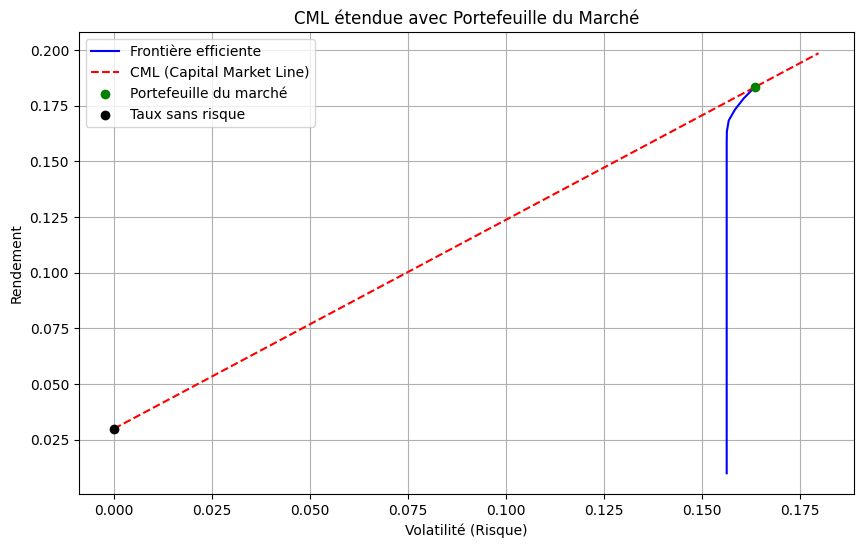

Portefeuille du marché :
Volatilité : 0.163336739190887
Rendement : 0.18323232323232325
Poids : [0.10767677 0.1        0.45528193 0.1        0.2370413 ]


In [181]:
def efficient_portfolio(mu_target, range_=(-0.1, None)):
  # Initialisation des poids
  init_weights = np.ones(n_assets) / n_assets
  init_weights = init_weights

  # Contraintes
  constraints = [
      {'type': 'eq', 'fun': weight_sum_constraint},
      {'type': 'ineq', 'fun': lambda w: target_return_constraint(w, mu_target)}
  ]

  # Contraintes de positivité (pas de vente à découvert)
  bounds = [range_ for _ in range(n_assets)]

  result = minimize(optim_fonction, init_weights, bounds= bounds, method='SLSQP', constraints=constraints)
  if result.success:
    optimal_weights = result.x
    portfolio_volatility = np.sqrt(portfolio_variance(optimal_weights))
    return portfolio_volatility, optimal_weights
  else :
    return None,None

rf = 0.03
mu_targets_ = np.linspace(0.01, 0.5, 100)  # Rendements cibles
sml_volatilities = []
sml_weights = []
mu_targets = []
# Calcul de la frontière efficiente
for mu_target in mu_targets_:
    vol, weights = efficient_portfolio(mu_target, (0.1, 1))
    if ((vol is not None) and (weights is not None)):
      sml_volatilities.append(vol)
      sml_weights.append(weights)
      mu_targets.append(mu_target)

# Identifier le portefeuille tangent (maximisation du ratio de Sharpe)
sharpe_ratios = (np.array(mu_targets) - rf) / np.array(sml_volatilities)
market_index = np.argmax(sharpe_ratios)
market_volatility = sml_volatilities[market_index]
market_return = mu_targets[market_index]
market_weights = sml_weights[market_index]

# Pente de la CML (ratio de Sharpe du marché)
cml_slope = (market_return - rf) / market_volatility

# Étendre la CML (droite reliant rf au-delà du portefeuille du marché)
extended_volatilities = np.linspace(0, max(sml_volatilities) * 1.1, 200)
cml_y = rf + cml_slope * extended_volatilities

# Tracer la frontière efficiente
plt.figure(figsize=(10, 6))
plt.plot(sml_volatilities, mu_targets, label="Frontière efficiente", color="blue")

# Tracer la CML (étendue)
plt.plot(extended_volatilities, cml_y, label="CML (Capital Market Line)", color="red", linestyle="--")

# Marquer le portefeuille du marché
plt.scatter([market_volatility], [market_return], color="green", label="Portefeuille du marché", zorder=5)

# Marquer le taux sans risque
plt.scatter([0], [rf], color="black", label="Taux sans risque", zorder=5)

# Graphique
plt.title("CML étendue avec Portefeuille du Marché")
plt.xlabel("Volatilité (Risque)")
plt.ylabel("Rendement")
plt.legend()
plt.grid()
plt.show()

print("Portefeuille du marché :")
print("Volatilité :", market_volatility)
print("Rendement :", market_return)
print("Poids :", market_weights)

In [194]:
fig = go.Figure()

# Tracer la frontière efficiente
fig.add_trace(go.Scatter(
    x=sml_volatilities,
    y=mu_targets,
    mode="lines",
    name="Frontière efficiente",
    line=dict(color="blue")
))

# Tracer la CML (Capital Market Line)
fig.add_trace(go.Scatter(
    x=extended_volatilities,
    y=cml_y,
    mode="lines",
    name="CML (Capital Market Line)",
    line=dict(color="red", dash="dash")
))

# Marquer le portefeuille du marché
fig.add_trace(go.Scatter(
    x=[market_volatility],
    y=[market_return],
    mode="markers",
    name="Portefeuille du marché",
    marker=dict(color="green", size=5)
))

# Marquer le taux sans risque
fig.add_trace(go.Scatter(
    x=[0],
    y=[rf],
    mode="markers",
    name="Taux sans risque",
    marker=dict(color="black", size=5)
))

# Mise en forme du graphique
fig.update_layout(
    title="CML étendue avec Portefeuille du Marché",
    xaxis_title="Volatilité (Risque)",
    yaxis_title="Rendement",
    showlegend=True,
    template="plotly_white",
    width = 900,
    yaxis=dict(showgrid=True),
    xaxis=dict(
        showgrid=True,
    )
)

# Afficher le graphique
fig.show()

In [179]:
data.columns

Index(['ISIN', 'Bloomberg Ticker', 'Title', 'Sector zone', 'Country', 'Zone',
       'Company Name', 'LEI', 'Near term - Target Status',
       'Near term - Target Classification', 'Company', 'Sector',
       'Accès à l'information',
       'Renforcement des compétences (formation, éducation, aides aux PME)',
       'Energie et changement climatique', 'Alimentation et Nutrition',
       'Santé', 'Infrastructure', 'Finance Responsable', 'Eau et Hygiène',
       'Protection des écosystèmes', 'SEDOL', 'Alcool',
       'Activités nuisant au bienêtre animal (tests, fourrure, etc)',
       'Produits chimiques controversés', 'Jeux d'argents et de hasard',
       'Organismes genertiquement modifiés', 'Prêts usuriers',
       'Energie Nucléaire', 'Divertissements pour Adultes',
       'Medecine reproductive', 'Tabac', 'Energies fossiles (Overall)',
       'Charbon', 'Fossile non conventionnel', 'Armes à feu civiles',
       'Matériel Militaire',
       'Armement controversé (Armes de destructio